In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import tensorflow as tf
import recommender
from recommender import Recommender, FactorizationRecommender, BPRRecommender, ImplicitBPRRecommender, WalsRecommender, ImplicitWalsRecommender, TopItemsRecommender
from matrix_builder import ReportTechniqueMatrixBuilder
from tie import TechniqueInferenceEngine
from constants import PredictionMethod
import random
import math
import importlib
import pandas as pd
import numpy as np
import sklearn.manifold
import matplotlib.pyplot as plt

tf.config.run_functions_eagerly(True)

assert tf.executing_eagerly()

importlib.reload(recommender)


/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'recommender' from '/Users/mjturner/code/technique-inference-engine/models/recommender/__init__.py'>

In [2]:
validation_ratio = 0.1
test_ratio = 0.2

# data locations
dataset_filepath = "../data/combined_dataset_full_frequency.json"
enterprise_attack_filepath = "../enterprise-attack.json"

# make data
data_builder = ReportTechniqueMatrixBuilder(
    combined_dataset_filepath=dataset_filepath,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
data = data_builder.build()

# split into training and test data
num_data_observations = len(data.indices)
num_train_and_validation_indices = math.floor((1-test_ratio) * num_data_observations)
num_validation_indices = math.floor(validation_ratio * num_data_observations)
num_train_indices = num_train_and_validation_indices - num_validation_indices
num_test_indices = num_data_observations - num_train_and_validation_indices

train_and_validation_indices = frozenset(random.sample(data.indices, k=num_train_and_validation_indices))
validation_indices = frozenset(random.sample(tuple(train_and_validation_indices), k=num_validation_indices))
train_indices = frozenset(train_and_validation_indices).difference(validation_indices)
test_indices = frozenset(data.indices).difference(train_and_validation_indices)

assert len(train_indices) + len(test_indices) + len(validation_indices) == num_data_observations

training_data = data.mask(train_indices)
validation_data = data.mask(validation_indices)
test_data = data.mask(test_indices)

print("Num training observations", training_data.to_numpy().sum())
print("Num validation observations", validation_data.to_numpy().sum())
print("Num test observations", test_data.to_numpy().sum())

Num training observations 33310.0
Num validation observations 4758.0
Num test observations 9518.0


In [4]:
oilrig_techniques = {
    "T1047", "T1059.005", "T1124", "T1082",
    "T1497.001", "T1053.005", "T1027", "T1105",
    "T1070.004", "T1059.003", "T1071.001"
}

In [3]:

def test_multiple_embeding_dimensions(model_class: Recommender, method: PredictionMethod, out_file: str, **kwargs):
    """Runs model_class at multiple embedding dimensions and saves results.

    Runs each model for embedding dimensions 4, 8, 10, 16, 32, and 64.

    Args:
        model_class: A model on which to train at multiple embedding dimensions.
        out_file: filename for saving the results file.  Requires len(out_file) > 0
            and out_file is a valid csv filename.
        kwargs: Parameters mapped to values.

    Mutates:
        Saves model results, including embedding_dimension, hyperparameters,
        and precision, recall, and ndcg at 10, 20, 50, and 100 to out_file.
    """
    assert len(out_file) > 0

    results = []

    embedding_dimensions = (4,8,10,16,32,64)
    # for every embedding
    for embedding_dimension in embedding_dimensions:

        # make model
        model = model_class(
            m=training_data.m,
            n=training_data.n,
            k=embedding_dimension,
        )

        # make tie
        tie = TechniqueInferenceEngine(
            training_data=training_data,
            validation_data=validation_data,
            test_data=test_data,
            model=model,
            prediction_method=method,
            enterprise_attack_filepath=enterprise_attack_filepath,
        )

        # fit hyperparameters
        best_hyperparameters = tie.fit_with_cross_validation(**kwargs)

        # calculate precision, recall, ndcg
        run_stats = {
            "embedding_dimension": embedding_dimension,
            **best_hyperparameters
        }
        k_values = (10, 20, 50, 100)
        for k in k_values:
            run_stats[f"precision_at_{k}"] = tie.precision(k=k)
            run_stats[f"recall_at_{k}"] = tie.recall(k=k)
            run_stats[f"ndcg_at_{k}"] = tie.normalized_discounted_cumulative_gain(k=k)

        print(run_stats)
        results.append(run_stats)


    # save as csv
    results_dataframe = pd.DataFrame(results)
    results_dataframe.to_csv(out_file)

In [5]:
test_multiple_embeding_dimensions(
    model_class=WalsRecommender,
    method=PredictionMethod.DOT,
    out_file="wals_model_results_training_data_correction_dot.csv",
    num_iterations=[25],
    c=[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    regularization_coefficient=[0.0, 0.00001, 0.0001, 0.001, 0.01]
)

In [6]:
test_multiple_embeding_dimensions(
    BPRRecommender,
    out_file="bpr_model_results.csv",
    num_iterations=[20*training_data.m*training_data.n],
    learning_rate=[0.00001, 0.00005, 0.0001, 0.001],
    regularization=[0., 0.0001, 0.001, 0.01],
)

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

{'embedding_dimension': 4, 'regularization': 0.0001, 'learning_rate': 0.0001, 'num_iterations': 76521640, 'precision_at_10': 0.01560204407537528, 'recall_at_10': 0.06050501513663635, 'ndcg_at_10': 0.07683413537968624, 'precision_at_20': 0.011992973490897476, 'recall_at_20': 0.09067910772439934, 'ndcg_at_20': 0.09634989967193944, 'precision_at_50': 0.0079112104758863, 'recall_at_50': 0.14733022592714648, 'ndcg_at_50': 0.12541038111253533, 'precision_at_100': 0.00527946343021399, 'recall_at_100': 0.1978219117723097, 'ndcg_at_100': 0.1456379374612586}


/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

{'embedding_dimension': 8, 'regularization': 0.001, 'learning_rate': 0.0001, 'num_iterations': 76521640, 'precision_at_10': 0.012791440434366017, 'recall_at_10': 0.048452527172814557, 'ndcg_at_10': 0.06212604210714955, 'precision_at_20': 0.010012775471095497, 'recall_at_20': 0.07689506441974149, 'ndcg_at_20': 0.07903656541040587, 'precision_at_50': 0.006547428936442032, 'recall_at_50': 0.12561008986844754, 'ndcg_at_50': 0.10273975134585815, 'precision_at_100': 0.004500159693388694, 'recall_at_100': 0.17281461717597588, 'ndcg_at_100': 0.12142186359861892}


/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

{'embedding_dimension': 10, 'regularization': 0.001, 'learning_rate': 0.0001, 'num_iterations': 76521640, 'precision_at_10': 0.011992973490897476, 'recall_at_10': 0.04644692238371199, 'ndcg_at_10': 0.05802910032592288, 'precision_at_20': 0.009374001916320665, 'recall_at_20': 0.0721340954731668, 'ndcg_at_20': 0.07385875110489287, 'precision_at_50': 0.006055573299265411, 'recall_at_50': 0.11468008558455581, 'ndcg_at_50': 0.09530259678856781, 'precision_at_100': 0.004227083998722453, 'recall_at_100': 0.16112090162064058, 'ndcg_at_100': 0.1135609038916972}


/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

{'embedding_dimension': 16, 'regularization': 0.0001, 'learning_rate': 0.0001, 'num_iterations': 76521640, 'precision_at_10': 0.010923027786649633, 'recall_at_10': 0.04140103153989063, 'ndcg_at_10': 0.05513784313726271, 'precision_at_20': 0.008312040881507506, 'recall_at_20': 0.0647656160113604, 'ndcg_at_20': 0.06839756124757733, 'precision_at_50': 0.005416799744490578, 'recall_at_50': 0.10646787811167806, 'ndcg_at_50': 0.08773154884648639, 'precision_at_100': 0.0039603960396039604, 'recall_at_100': 0.15611050618282554, 'ndcg_at_100': 0.10676608984315174}


/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:107: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)
/Users/mjturner/code/tech

In [5]:
embedding_dimension = 10
k = 20
best_hyperparameters = {'gravity_coefficient': 0.001, 'regularization_coefficient': 0.5, 'num_iterations': 1000, 'learning_rate': 100.0}

model = TopItemsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.DOT,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit()
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 0.058110197462322474
Precision 0.02456882785052699
Recall 0.19636470430463612
Normalized Discounted Cumulative Gain 0.18549855195023673


In [6]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

           predictions  training_data  test_data  \
T1592.004     0.000000            0.0        0.0   
T1557.001     0.586885            0.0        0.0   
T1600         0.291803            0.0        0.0   
T1647         0.293443            0.0        0.0   
T1068         0.916393            0.0        0.0   
...                ...            ...        ...   
T1656         0.149180            0.0        0.0   
T1557.003     0.147541            0.0        0.0   
T1499.001     0.145902            0.0        0.0   
T1027.005     0.708197            0.0        0.0   
T1059.007     0.896721            0.0        0.0   

                                  technique_name  
T1592.004                  Client Configurations  
T1557.001   LLMNR/NBT-NS Poisoning and SMB Relay  
T1600                          Weaken Encryption  
T1647                    Plist File Modification  
T1068      Exploitation for Privilege Escalation  
...                                          ...  
T1656             

In [14]:
embedding_dimension = 10
k = 20
best_hyperparameters = {'gravity_coefficient': 0.001, 'regularization_coefficient': 0.001, 'num_iterations': 10, 'learning_rate': 1.0}

model = FactorizationRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.DOT,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     learning_rate=[0.001, 0.01, 0.1, 1.0, 10., 20., 50., 100.],
#     num_iterations=[1000],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
#     gravity_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)


Mean Squared Error 8.34052287499289
Precision 0.001365378473331204
Recall 0.012396331799078527
Normalized Discounted Cumulative Gain 0.00881284425930953


In [15]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

            predictions  training_data  test_data  \
T1558.002  79587.203125            0.0        0.0   
T1132.002   2069.376465            0.0        0.0   
T1211     -17206.457031            0.0        0.0   
T1601.002  10626.997070            0.0        0.0   
T1596      -8066.793945            0.0        0.0   
...                 ...            ...        ...   
T1546.011 -38596.539062            0.0        0.0   
T1535     -17057.259766            0.0        0.0   
T1071      10676.069336            0.0        0.0   
T1587      36317.167969            0.0        0.0   
T1499.002  19678.314453            0.0        0.0   

                             technique_name  
T1558.002                     Silver Ticket  
T1132.002             Non-Standard Encoding  
T1211      Exploitation for Defense Evasion  
T1601.002            Downgrade System Image  
T1596       Search Open Technical Databases  
...                                     ...  
T1546.011              Application Shimmi

In [16]:
# hyperparameters
embedding_dimension = 4
k = 20
best_hyperparameters = {'regularization_coefficient': 0.0001, 'num_iterations': 256, 'learning_rate': 0.0001}
# best_hyperparameters["num_iterations"] = 20*training_data.m*training_data.n

model = BPRRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.COSINE,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
# mse = tie.fit_with_cross_validation(
#     learning_rate=[0.001, 0.005, 0.01, 0.02, 0.05],
#     num_iterations=[500 * 512],
#     regularization=[0, 0.0001, 0.001, 0.01],
# )
mse = tie.fit(**best_hyperparameters)
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=20)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 1.2318953
Precision 0.0023794314915362505
Recall 0.01838211860627646
Normalized Discounted Cumulative Gain 0.015273090230587916


In [17]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

           predictions  training_data  test_data  \
T1558.002     0.555484            0.0        0.0   
T1132.002     0.494036            0.0        0.0   
T1211        -0.492932            0.0        0.0   
T1601.002    -0.185998            0.0        0.0   
T1596        -0.025210            0.0        0.0   
...                ...            ...        ...   
T1546.011    -0.217676            0.0        0.0   
T1535         0.464719            0.0        0.0   
T1071         0.199836            0.0        0.0   
T1587         0.658772            0.0        0.0   
T1499.002     0.464182            0.0        0.0   

                             technique_name  
T1558.002                     Silver Ticket  
T1132.002             Non-Standard Encoding  
T1211      Exploitation for Defense Evasion  
T1601.002            Downgrade System Image  
T1596       Search Open Technical Databases  
...                                     ...  
T1546.011              Application Shimming  
T1535  

In [18]:
# hyperparameters
embedding_dimension = 10
k = 20
best_hyperparameters = {'regularization': 0.0001, 'num_iterations': 256000, 'learning_rate': 0.005}

best_hyperparameters["num_iterations"] = 50
model = ImplicitBPRRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.COSINE,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
# mse = tie.fit_with_cross_validation(
#     learning_rate=[0.001, 0.005, 0.01, 0.02, 0.05],
#     num_iterations=[math.floor(500 * 512 / training_data.to_numpy().sum())],
#     regularization=[0, 0.0001, 0.001, 0.01],
# )
mse = tie.fit(**best_hyperparameters)
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

  0%|          | 0/50 [00:00<?, ?it/s]

Mean Squared Error 1.1135675464313306
Precision 0.004375598850207602
Recall 0.033039188552485374
Normalized Discounted Cumulative Gain 0.029512367719361752


In [19]:
# hyperparameters
embedding_dimension = 10
k = 20

best_hyperparameters = {'regularization_coefficient': 0.05, 'c': 0.5, 'num_iterations': 20}

model = ImplicitWalsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.COSINE,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     num_iterations=[20],
#     c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05]
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

/home/mjturner/miniconda3/envs/py311/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 36 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

Mean Squared Error 0.7720959112337613
Precision 0.03188278505269882
Recall 0.3298013314687184
Normalized Discounted Cumulative Gain 0.020399515720015082


In [20]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

           predictions  training_data  test_data  \
T1558.002     0.047956            0.0        0.0   
T1132.002     0.278666            0.0        0.0   
T1211         0.078939            0.0        0.0   
T1601.002     0.000000            0.0        0.0   
T1596         0.147958            0.0        0.0   
...                ...            ...        ...   
T1546.011     0.319117            0.0        0.0   
T1535         0.000000            0.0        0.0   
T1071         0.151614            0.0        0.0   
T1587         0.234140            0.0        0.0   
T1499.002    -0.120075            0.0        0.0   

                             technique_name  
T1558.002                     Silver Ticket  
T1132.002             Non-Standard Encoding  
T1211      Exploitation for Defense Evasion  
T1601.002            Downgrade System Image  
T1596       Search Open Technical Databases  
...                                     ...  
T1546.011              Application Shimming  
T1535  

In [21]:
# hyperparameters
embedding_dimension = 4
k = 20

# best_hyperparameters = {'regularization_coefficient': 0.1, 'c': 0.5, 'num_iterations': 20}
# best_hyperparameters = {'regularization_coefficient': 0.0001, 'c': 0.3, 'num_iterations': 100}
best_hyperparameters = {'regularization_coefficient': 0.001, 'c': 0.1, "num_iterations": 20}
model = WalsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    prediction_method=PredictionMethod.COSINE,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     num_iterations=[20],
#     c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05]
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 0.6764495842495176
Precision 0.0319466624081763
Recall 0.3309393047808232
Normalized Discounted Cumulative Gain 0.021621860388003213


In [23]:
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, **best_hyperparameters)
print(new_report_predictions)

           predictions  training_data  test_data  \
T1558.002     0.372191            0.0        0.0   
T1132.002     0.814301            0.0        0.0   
T1211        -0.219102            0.0        0.0   
T1601.002     0.000000            0.0        0.0   
T1596        -0.297662            0.0        0.0   
...                ...            ...        ...   
T1546.011     0.325952            0.0        0.0   
T1535         0.000000            0.0        0.0   
T1071         0.273710            0.0        0.0   
T1587         0.480159            0.0        0.0   
T1499.002    -0.273072            0.0        0.0   

                             technique_name  
T1558.002                     Silver Ticket  
T1132.002             Non-Standard Encoding  
T1211      Exploitation for Defense Evasion  
T1601.002            Downgrade System Image  
T1596       Search Open Technical Databases  
...                                     ...  
T1546.011              Application Shimming  
T1535  

In [18]:
# TEMPORARY - GET EMBEDDINGS FOR FE
U = tie.get_U() # entity (report) ids
V = tie.get_V() # item (technique) embeddings

U_with_index = np.hstack((np.expand_dims(training_data.report_ids, axis=1), U))
V_with_index = np.hstack((np.expand_dims(training_data.technique_ids, axis=1), V))

print(U_with_index.shape)
print(V_with_index.shape)

[[ 0.00000000e+00  3.10272485e-01 -5.06079257e-01 ... -2.96728946e-02
   1.03696346e-01 -4.59698914e-03]
 [ 1.00000000e+00  2.34661356e-01 -3.45782340e-01 ... -8.81108269e-02
   7.32592419e-02  2.15996355e-01]
 [ 2.00000000e+00  4.81936446e-08  6.88791080e-10 ...  3.42836657e-08
  -7.81015075e-09 -4.81467985e-08]
 ...
 [ 6.25900000e+03  3.53572398e-01 -4.88738894e-01 ...  2.14364976e-02
   1.39371127e-01  1.01979606e-01]
 [ 6.26000000e+03 -5.61978075e-10 -3.23640350e-08 ... -7.43976116e-08
   8.64229861e-08  8.77083117e-09]
 [ 6.26100000e+03 -6.00948269e-08 -1.48262300e-08 ...  3.57593208e-08
  -9.07301079e-09  2.34565452e-08]]
(6262, 11)
(611, 11)


recalls [0.3087573406401257, 0.3257859760812914, 0.3458226653670225, 0.3745375233589626, 0.3949941633991787, 0.4110964558541681, 0.4219309973671012, 0.4317147374599419, 0.44042389049516534, 0.44770298702149547, 0.45387773687027355, 0.45797033624322875, 0.46304119765720547, 0.4679221448741617, 0.47182791494477766, 0.47617333685846847, 0.4791363202775644, 0.48264413250862803, 0.48577394889957126, 0.4883141430997783, 0.4904385260449852]


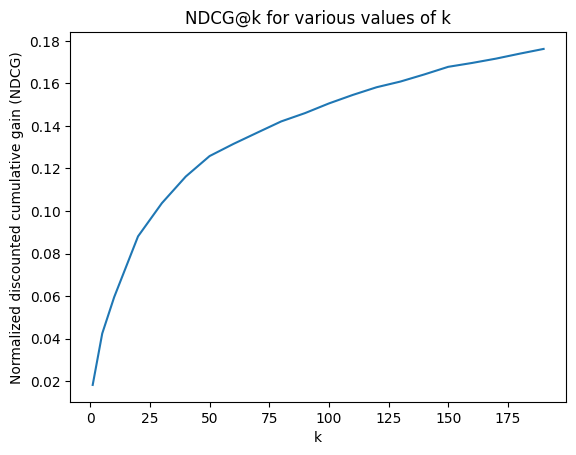

In [8]:
k_values = [1, 5] + list(range(10, 200, 10))
recalls = []
ndcgs = []
for k in k_values:
    # print("Mean Squared Error", mse)
    precision = tie.precision(k=k)
    # print("Precision", precision)
    recall = tie.recall(k=k)
    recalls.append(recall)
    # print("Recall", recall)
    ndcg = tie.normalized_discounted_cumulative_gain(k=k)
    ndcgs.append(ndcg)
    # print("Normalized Discounted Cumulative Gain", ndcg)

print("recalls", recalls)

plt.xlabel("k")
plt.ylabel("Normalized discounted cumulative gain (NDCG)")
plt.title("NDCG@k for various values of k")
plt.plot(k_values, ndcgs)

In [6]:
oilrig_techniques = {
    "T1047", "T1059.005", "T1124", "T1082",
    "T1497.001", "T1053.005", "T1027", "T1105",
    "T1070.004", "T1059.003", "T1071.001"
}
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, c=0.5, regularization_coefficient=0.05, learning_rate=0.01, num_iterations=100)

print(new_report_predictions.sort_values(by="predictions", ascending=False).head(10))

TypeError: FactorizationRecommender.predict_new_entity() got an unexpected keyword argument 'c'

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 6262 samples in 0.003s...
[t-SNE] Computed neighbors for 6262 samples in 0.226s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6262
[t-SNE] Computed conditional probabilities for sample 2000 / 6262
[t-SNE] Computed conditional probabilities for sample 3000 / 6262
[t-SNE] Computed conditional probabilities for sample 4000 / 6262
[t-SNE] Computed conditional probabilities for sample 5000 / 6262
[t-SNE] Computed conditional probabilities for sample 6000 / 6262
[t-SNE] Computed conditional probabilities for sample 6262 / 6262
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.187531
[t-SNE] KL divergence after 10000 iterations: 0.847868


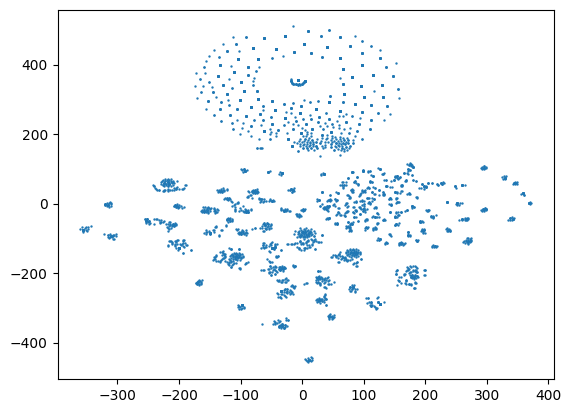

In [11]:
def make_tsne_embeddings(embeddings: np.ndarray) -> tuple[np.array, np.array]:
    """Create 2D representation of embeddings using t-SNE.

    Args:
        embeddings: an mxk array of m embeddings in k-dimensional space.

    Returns:
        A tuple of the form (x_1, x_2) where x_1 and x_2 are length m
        such that (x_1[i], x_2[i]) is the 2-dimensional point cotnaining the 2-dimensional
        repsresentation for embeddings[i, :].
    """
    tsne = sklearn.manifold.TSNE(
        n_components=2,
        perplexity=15,
        learning_rate="auto",
        # metric='cosine',
        # early_exaggeration=10.0,
        init='pca',
        verbose=True,
        n_iter=10000,
    )

    V_proj = tsne.fit_transform(embeddings)
    x = V_proj[:, 0]
    y = V_proj[:, 1]

    return x, y

U = tie.get_U()
x_1, x_2 = make_tsne_embeddings(U)

plt.scatter(x_1, x_2, s=0.5)
plt.show()